In [1]:
from PIL import Image
import torch
from torch import nn, optim
import glob
import os
import pandas as pd
import json
import numpy as np
import clip
from torch.utils.data import Dataset, DataLoader, BatchSampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from matplotlib.pyplot import imshow
import torchtext
import nltk, re, string, collections
from nltk.util import ngrams
import collections
%matplotlib inline
BATCH_SIZE = 8
EPOCH = 5

# Preparing Model and Data

In [2]:
IMG_ROOT = "./input/meme-project-raw"
IMG_SEG_ROOT = "./input/meme-raw-seg"
JSON_ROOT = "./input/meme-project-clean-json"
img_paths = glob.glob(os.path.join(IMG_ROOT, "*.jpg"))
img_seg_paths = glob.glob(os.path.join(IMG_SEG_ROOT, "*.jpg"))

d = {}
d_seg = {}

for img_path in img_paths:
    name = img_path.split("/")[-1].split(".")[0]
    if not os.path.exists(os.path.join(IMG_ROOT, name + ".json")):
        continue
    with open(os.path.join(JSON_ROOT, name+".json"), "r") as f:
        if len(d) / 500 in range((len(d) // 500) + 1):
            print(f"{len(d) + 1}: {os.path.join(IMG_ROOT, name + '.jpg')}")
        captions = json.load(f)
        temp = []
        for cap in captions:
            if "http" not in (cap[0] + ' ' + cap[1]) and len(cap[0] + ' ' + cap[1]) >= 8 and len(cap[0] + ' ' + cap[1]) <= 72:
                temp.append(cap[0] + ' ' + cap[1])
        d[img_path] = temp
        
i = 0
for img_path in img_seg_paths:
    i += 1
    name = img_path.split("/")[-1].split(".")[0]
    if not os.path.exists(os.path.join(JSON_ROOT, name + ".json")):
        print(os.path.join(IMG_SEG_ROOT, name + ".json not found, skipping"))
        img_seg_paths.remove(os.path.join(IMG_SEG_ROOT, name + ".jpg"))
        continue
    with open(os.path.join(JSON_ROOT, name + ".json"), "r") as f:
        if len(d_seg) / 500 in range((len(d_seg) // 500) + 1):
            print(f"{len(d_seg) + 1}: {os.path.join(IMG_SEG_ROOT, name + '.jpg')}")
        captions = json.load(f)
        temp = []
        for cap in captions:
            if "http" not in (cap[0]+ ' '+cap[1]) and len(cap[0]+ ' '+cap[1]) >= 8 and len(cap[0]+ ' '+cap[1]) <= 72:
                temp.append(cap[0]+ ' '+cap[1])
        d_seg[img_path] = temp
    if len(d_seg.keys()) != i:
        print(f"{img_path} \t{name} failed to load json")
        
len(d), len(d_seg)

1: ./input/meme-project-raw/absent-minded-looch.jpg
501: ./input/meme-project-raw/oblivious-activist-goat.jpg
1001: ./input/meme-project-raw/typical-boy.jpg
1501: ./input/meme-project-raw/guess-who-you.jpg
2001: ./input/meme-project-raw/dr-steve-brule.jpg
2501: ./input/meme-project-raw/vip2-gayle.jpg
1: ./input/meme-raw-seg/absent-minded-looch.jpg
501: ./input/meme-raw-seg/neymarin.jpg
1001: ./input/meme-raw-seg/zayn-malik1.jpg
1501: ./input/meme-raw-seg/kd-you-the-real-mvp-f.jpg
2001: ./input/meme-raw-seg/svobodus-vulgaris.jpg
2501: ./input/meme-raw-seg/this-is-stas.jpg


(3000, 2535)

## Splitting 20% for Validation

In [3]:
train_img_paths, test_img_paths = train_test_split(img_paths, test_size=0.2, random_state=42)
train_img_seg_paths, test_img_seg_paths = train_test_split(img_seg_paths, test_size=0.2, random_state=42)

d_train = {k: d[k] for k in train_img_paths}
d_test = {k: d[k] for k in test_img_paths}

d_seg_train = {k: d_seg[k] for k in train_img_seg_paths}
d_seg_test = {k: d_seg[k] for k in test_img_seg_paths}

print(f"base split: {len(d_train)}, {len(d_test)}")
print(f"custom split: {len(d_seg_train)}, {len(d_seg_test)}")

base split: 2400, 600
custom split: 2028, 507


## Loading Pre-trained CLIP Model and Preprocessor

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_1e, preprocess_1e = clip.load("ViT-B/32", device=device, jit=False)
model_cs, preprocess_cs = clip.load("ViT-B/32", device=device, jit=False)

image = preprocess(Image.open("./input/meme-project-raw/-okay-.jpg")).unsqueeze(0).to(device)
image_1e = preprocess_1e(Image.open("./input/meme-project-raw/-okay-.jpg")).unsqueeze(0).to(device)
image_cs = preprocess_cs(Image.open("./input/meme-project-raw/-okay-.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
print(f"{image_1e.shape}, {image_cs.shape}, {text.shape}")

torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]), torch.Size([3, 77])


## Initializing a student model

In [6]:
model_stud, preprocess_stud = clip.load("ViT-B/32", device=device, jit=False) # другой preprocess для уменьшенного width?
print(f"initial params vision: {model_stud.visual.transformer.width}, {model_stud.visual.transformer.layers}")
print(f"initial params text: {model_stud.transformer.width}, {model_stud.transformer.layers}")

initial params vision: 768, 12
initial params text: 512, 12


## Reduced size student

In [7]:
#student_vision = clip.model.VisionTransformer(input_resolution = 224, patch_size = 32, width = 768 // 2, layers=12 // 2, heads = 12, output_dim = 512)
#student_text = clip.model.Transformer(width = 512 // 2, layers = 12 // 2, heads = 8 // 2) # assertion width % heads = 0

## Full size student

In [8]:
#student_vision = clip.model.VisionTransformer(input_resolution = 224, patch_size = 32, width = 768, layers=12, heads = 12, output_dim = 512)
#student_text = clip.model.Transformer(width = 512, layers = 12, heads = 8)

## Replacing ViT-B/32's visual transformer with `student`

In [9]:
#student_vision.conv1 = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=32, stride=32, bias=False, device=device, dtype=model_stud.dtype)
#def apply_cuda(m):
#    print(f"applying cuda to {m}")
#    m.cuda()

#model_stud.visual = student_vision
#model_stud.transformer = student_text

#model_stud.apply(apply_cuda)

print(f"new params vision: {model_stud.visual.transformer.width}, {model_stud.visual.transformer.layers}")
print(f"new params text: {model_stud.transformer.width}, {model_stud.transformer.layers}")

image_stud = preprocess_stud(Image.open("./input/meme-project-raw/-okay-.jpg")).unsqueeze(0).to(device)

new params vision: 768, 12
new params text: 512, 12


## Applying CUDA to new model

In [10]:
#device_holder = torch.jit.trace(lambda: torch.ones([]).to(torch.device(device)), example_inputs=[])
#device_node = [n for n in device_holder.graph.findAllNodes("prim::Constant") if "Device" in repr(n)][-1]
#
#def patch_device(module):
#    try:
#        graphs = [module.graph] if hasattr(module, "graph") else []
#    except RuntimeError:
#        graphs = []
#
#    if hasattr(module, "forward1"):
#        graphs.append(module.forward1.graph)
#
#    for graph in graphs:
#        for node in graph.findAllNodes("prim::Constant"):
#            if "value" in node.attributeNames() and str(node["value"]).startswith("cuda"):
#                node.copyAttributes(device_node)
#
#model_stud.apply(patch_device)
#patch_device(model_stud.encode_image)
#patch_device(model_stud.encode_text)

In [11]:
torch.cuda.is_available()

True

## MemeDataset

In [12]:
class MemeDataset(Dataset):
    def __init__(self, data, preprocess):
        self.preprocess = preprocess
        self.img_paths = []
        self.captions = []
        for img_path, captions in data.items():
            for cap in captions:
                self.img_paths.append(img_path)
                self.captions.append(cap)
        self.processed_cache = {}
        for img_path in data:
            self.processed_cache[img_path] = self.preprocess(Image.open(img_path))
        self.img_paths_set = list(data.keys())
        self.path2label = {path: self.img_paths_set.index(path) for path in self.img_paths_set}
        
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = self.processed_cache[img_path]
        caption = self.captions[idx]
        label = self.path2label[img_path]
        return image, caption, label

train_dataset = MemeDataset(d_train, preprocess)
test_dataset = MemeDataset(d_test, preprocess)

train_seg_dataset = MemeDataset(d_seg_train, preprocess_cs)
test_seg_dataset = MemeDataset(d_seg_test, preprocess_cs)

train_1e_dataset = MemeDataset(d_seg_train, preprocess_1e)
test_1e_dataset = MemeDataset(d_seg_test, preprocess_1e)

train_stud_dataset = MemeDataset(d_seg_train, preprocess_stud)
test_stud_dataset = MemeDataset(d_seg_test, preprocess_stud)

print(f"{len(train_dataset)}, {len(test_dataset)}")
print(f"{len(train_seg_dataset)}, {len(test_seg_dataset)}")
print(f"{len(train_1e_dataset)}, {len(test_1e_dataset)}")
print(f"{len(train_stud_dataset)}, {len(test_stud_dataset)}")

238418, 60319
195683, 49376
195683, 49376
195683, 49376


In [13]:
i = 0
for k,v in train_seg_dataset.path2label.items():
    i+=1
    print(f"{i}) {k}, {v}")
    if i == 5:
        break
print("-"*48)
i = 0
for k,v in train_1e_dataset.path2label.items():
    i+=1
    print(f"{i}) {k}, {v}")
    if i == 5:
        break
print("-"*48)
i = 0
for k,v in train_stud_dataset.path2label.items():
    i+=1
    print(f"{i}) {k}, {v}")
    if i == 5:
        break

1) ./input/meme-raw-seg/super-ssau.jpg, 0
2) ./input/meme-raw-seg/female-internet-troll.jpg, 1
3) ./input/meme-raw-seg/y-u-no-bren-iwsnt.jpg, 2
4) ./input/meme-raw-seg/how-tough-are-you.jpg, 3
5) ./input/meme-raw-seg/dinosaur-director.jpg, 4
------------------------------------------------
1) ./input/meme-raw-seg/super-ssau.jpg, 0
2) ./input/meme-raw-seg/female-internet-troll.jpg, 1
3) ./input/meme-raw-seg/y-u-no-bren-iwsnt.jpg, 2
4) ./input/meme-raw-seg/how-tough-are-you.jpg, 3
5) ./input/meme-raw-seg/dinosaur-director.jpg, 4
------------------------------------------------
1) ./input/meme-raw-seg/super-ssau.jpg, 0
2) ./input/meme-raw-seg/female-internet-troll.jpg, 1
3) ./input/meme-raw-seg/y-u-no-bren-iwsnt.jpg, 2
4) ./input/meme-raw-seg/how-tough-are-you.jpg, 3
5) ./input/meme-raw-seg/dinosaur-director.jpg, 4


## BalancedBatchSampler (ensures no same class per batch)

In [14]:
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size
    
train_labels = torch.tensor([item[2] for item in train_dataset])
train_sampler = BalancedBatchSampler(train_labels, BATCH_SIZE, 1)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

test_labels = torch.tensor([item[2] for item in test_dataset])
test_sampler = BalancedBatchSampler(test_labels, BATCH_SIZE, 1)
test_dataloader = DataLoader(test_dataset, batch_sampler=test_sampler)

train_seg_labels = torch.tensor([item[2] for item in train_seg_dataset])
train_seg_sampler = BalancedBatchSampler(train_seg_labels, BATCH_SIZE, 1)
train_seg_dataloader = DataLoader(train_seg_dataset, batch_sampler=train_seg_sampler)

test_seg_labels = torch.tensor([item[2] for item in test_seg_dataset])
test_seg_sampler = BalancedBatchSampler(test_seg_labels, BATCH_SIZE, 1)
test_seg_dataloader = DataLoader(test_seg_dataset, batch_sampler=test_seg_sampler)

train_1e_labels = torch.tensor([item[2] for item in train_1e_dataset])
train_1e_sampler = BalancedBatchSampler(train_1e_labels, BATCH_SIZE, 1)
train_1e_dataloader = DataLoader(train_1e_dataset, batch_sampler=train_1e_sampler)

test_1e_labels = torch.tensor([item[2] for item in test_1e_dataset])
test_1e_sampler = BalancedBatchSampler(test_1e_labels, BATCH_SIZE, 1)
test_1e_dataloader = DataLoader(test_1e_dataset, batch_sampler=test_1e_sampler)

train_stud_labels = torch.tensor([item[2] for item in train_stud_dataset])
train_stud_sampler = BalancedBatchSampler(train_stud_labels, BATCH_SIZE, 1)
train_stud_dataloader = DataLoader(train_stud_dataset, batch_sampler=train_stud_sampler)

test_stud_labels = torch.tensor([item[2] for item in test_stud_dataset])
test_stud_sampler = BalancedBatchSampler(test_stud_labels, BATCH_SIZE, 1)
test_stud_dataloader = DataLoader(test_stud_dataset, batch_sampler=test_stud_sampler)

In [15]:
for i, item in enumerate(train_seg_sampler):
    labels = []
    for idx in item:
        label = train_seg_dataset[idx][2]
        labels.append(label)
    break
    
for i, item in enumerate(train_1e_sampler):
    labels_1e = []
    for idx in item:
        label = train_1e_dataset[idx][2]
        labels_1e.append(label)
    break

for i, item in enumerate(train_stud_sampler):
    labels_stud = []
    for idx in item:
        label = train_stud_dataset[idx][2]
        labels_stud.append(label)
    break
    
print(f"{len(labels)}, {len(set(labels))}")
print(f"{len(labels_1e)}, {len(set(labels_1e))}")
print(f"{len(labels_stud)}, {len(set(labels_stud))}")

8, 8
8, 8
8, 8


In [16]:
print("seg:\n")
for batch in train_seg_dataloader:
    imgs, txts, labels = batch
    print(imgs.shape)
    print(len(txts))
    print(labels)
    print(labels.shape)
    print(torch.unique(labels).shape)
    break

print("-"*90)

print("1e:\n")
for batch in train_1e_dataloader:
    imgs, txts, labels = batch
    print(imgs.shape)
    print(len(txts))
    print(labels)
    print(labels.shape)
    print(torch.unique(labels).shape)
    break

print("-"*90)

print("distilled:\n")
for batch in train_stud_dataloader:
    imgs, txts, labels = batch
    print(imgs.shape)
    print(len(txts))
    print(labels)
    print(labels.shape)
    print(torch.unique(labels).shape)
    break

seg:

torch.Size([8, 3, 224, 224])
8
tensor([1528,  451,  123, 1191, 1856,   21, 1993,  874])
torch.Size([8])
torch.Size([8])
------------------------------------------------------------------------------------------
1e:

torch.Size([8, 3, 224, 224])
8
tensor([1569, 1391, 1305,  917,  208,  956,  808, 1341])
torch.Size([8])
torch.Size([8])
------------------------------------------------------------------------------------------
distilled:

torch.Size([8, 3, 224, 224])
8
tensor([ 669,  896,  674, 1724, 1052,  560,  604,  329])
torch.Size([8])
torch.Size([8])


# Training

In [17]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

if device == "cpu":
    print("CUDA gpu not found")
    model.float()
    model_1e.float()
    model_cs.float()
    model_stud.float()

loss_img_1 = nn.KLDivLoss() #nn.CrossEntropyLoss()                                                                  # TODO: потрогать функции потерь
loss_img_2 = nn.L1Loss()
loss_txt = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader)*EPOCH)

optimizer_1e = optim.Adam(model_1e.parameters(), lr=1e-5)
scheduler_1e = optim.lr_scheduler.CosineAnnealingLR(optimizer_1e, len(train_1e_dataloader)*1)

optimizer_cs = optim.Adam(model_cs.parameters(), lr=1e-5)
scheduler_cs = optim.lr_scheduler.CosineAnnealingLR(optimizer_cs, len(train_seg_dataloader)*EPOCH)

optimizer_stud = optim.Adam(model_stud.parameters(), lr=1e-5)                                               # TODO: потрогать оптимизатор
scheduler_stud = optim.lr_scheduler.CosineAnnealingLR(optimizer_stud, len(train_stud_dataloader)*EPOCH)

In [18]:
# initTraining(model_cs, "cs", 4) => обучение модели model_cs, обученные файлы будут сохраняться с добавлением аппендикса "cs",
# обучение будет длиться 4 эпохи.
def totalLoss(losses_img, logits_per_image, logits_per_text, ground_truth):
    return (np.add.reduce([loss_img(logits_per_image, ground_truth) for loss_img in losses_img]) + loss_txt(logits_per_text, ground_truth)) / 2

def initTraining(model, train_dataloader, test_dataloader, optimizer, scheduler, appendix="base", EPOCH=EPOCH, losses_img=(nn.CrossEntropyLoss())):
    best_te_loss = 1e5
    best_ep = -1
    for epoch in range(EPOCH):
        print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
        step = 0
        tr_loss = 0
        model.train()
        pbar = tqdm(train_dataloader, leave=False)
        for batch in pbar:
            step += 1
            optimizer.zero_grad()

            images, texts, _ = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)
            logits_per_image, logits_per_text = model(images, texts)
            ground_truth = torch.arange(BATCH_SIZE).to(device)

            total_loss = totalLoss(losses_img, logits_per_image, logits_per_text, ground_truth)
            total_loss.backward()
            tr_loss += total_loss.item()
            if device == "cpu":
                optimizer.step()
                scheduler.step()
            else:
                convert_models_to_fp32(model)
                optimizer.step()
                scheduler.step()
                clip.model.convert_weights(model)
            pbar.set_description(f"train batchCE: {total_loss.item()}", refresh=True)
        tr_loss /= step

        step = 0
        te_loss = 0
        with torch.no_grad():
            model.eval()
            test_pbar = tqdm(test_dataloader, leave=False)
            for batch in test_pbar:
                step += 1
                images, texts, _ = batch
                images = images.to(device)
                texts = clip.tokenize(texts).to(device)
                logits_per_image, logits_per_text = model(images, texts)
                ground_truth = torch.arange(BATCH_SIZE).to(device)

                total_loss = totalLoss(losses_img, logits_per_image, logits_per_text, ground_truth)
                te_loss += total_loss.item()
                test_pbar.set_description(f"test batchCE: {total_loss.item()}", refresh=True)
            te_loss /= step

        if te_loss < best_te_loss:
            best_te_loss = te_loss
            best_ep = epoch
            torch.save(model.state_dict(), f"best_{appendix}_model.pt")
        print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")
    torch.save(model.state_dict(), f"last_{appendix}_model.pt")

In [19]:
#initTraining(model_cs, train_seg_dataloader, test_seg_dataloader, optimizer_cs, scheduler_cs, "cs", 5)

In [20]:
#initTraining(model_1e, train_1e_dataloader, test_1e_dataloader, optimizer_1e, scheduler_1e, "1e", 1)

# Distillation

In [21]:
# img_losses = [
#     nn.CrossEntropyLoss()
# ]

# text_losses = [
#     nn.CrossEntropyLoss()
# ]

# def classic_loss(ground_truth, img_losses, text_losses, lpi_student, lpt_student):
#     return np.add.reduce([li(ground_truth, lpi_student) for li in img_losses]) + \
#         np.add.reduce([lt(ground_truth, lpt_student) for lt in text_losses])

img_losses = nn.CrossEntropyLoss()
text_losses = nn.CrossEntropyLoss()

def classic_loss(ground_truth, img_losses, text_losses, lpi_student, lpt_student):
    return img_losses(lpi_student, ground_truth) + text_losses(lpt_student, ground_truth)

def teacher_hint(lpi_teacher, lpt_teacher, lpi_student, lpt_student, t=1):
    return 2 * (t ** 2) * \
        nn.functional.kl_div(\
            nn.functional.softmax(np.add.reduce([lpi_student.cpu().detach().float(), lpt_student.cpu().detach().float()]) / t), \
            nn.functional.softmax(np.add.reduce([lpi_teacher.cpu().detach().float(), lpt_teacher.cpu().detach().float()]) / t))

def loss(ground_truth, img_losses, text_losses, lpi_teacher, lpt_teacher, lpi_student, lpt_student, lbda=1, t=1):    
    return classic_loss(ground_truth, img_losses, text_losses, lpi_student, lpt_student) + \
        teacher_hint(lpi_teacher, lpt_teacher, lpi_student, lpt_student, t) * lbda

In [22]:
def initDistillation(model_teacher, model_student, train_dataloader, test_dataloader, optimizer, scheduler, epochs=EPOCH, appendix="base"):
    best_te_loss = 1e5
    best_ep = -1
    for epoch in range(epochs):
        print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
        step = 0
        tr_loss = 0
        model_student.train()
        pbar = tqdm(train_dataloader, leave=False)
        for batch in pbar:
            step += 1
            optimizer.zero_grad()

            images, texts, _ = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)
            lpi_teacher, lpt_teacher = model_teacher(images, texts)
            lpi_student, lpt_student = model_student(images, texts)
            ground_truth = torch.arange(BATCH_SIZE).to(device)

            total_loss = loss(ground_truth, img_losses, text_losses, lpi_teacher, lpt_teacher, lpi_student, lpt_student)
            total_loss.backward()
            tr_loss += total_loss.item()
            if device == "cpu":
                optimizer.step()
                scheduler.step()
            else:
                convert_models_to_fp32(model_student)
                optimizer.step()
                scheduler.step()
                clip.model.convert_weights(model_student)
            pbar.set_description(f"train batchCE: {total_loss.item()}", refresh=True)
        tr_loss /= step

        step = 0
        te_loss = 0
        with torch.no_grad():
            model_student.eval()
            test_pbar = tqdm(test_dataloader, leave=False)
            for batch in test_pbar:
                step += 1
                images, texts, _ = batch
                images = images.to(device)
                texts = clip.tokenize(texts).to(device)
                lpi_teacher, lpt_teacher = model_teacher(images, texts)
                lpi_student, lpt_student = model_student(images, texts)
                ground_truth = torch.arange(BATCH_SIZE).to(device)

                total_loss = loss(ground_truth, img_losses, text_losses, lpi_teacher, lpt_teacher, lpi_student, lpt_student)
                te_loss += total_loss.item()
                test_pbar.set_description(f"test batchCE: {total_loss.item()}", refresh=True)
            te_loss /= step

        if te_loss < best_te_loss:
            best_te_loss = te_loss
            best_ep = epoch
            torch.save(model_student.state_dict(), f"best_{appendix}_distilled_model.pt")
        print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")
    torch.save(model_student.state_dict(), f"last_{appendix}_distilled_model.pt")

In [23]:
model.load_state_dict(torch.load("./input/tuned-clips/best_model.pt"))
print(f"model cuda: {next(model.parameters()).is_cuda}, model_stud cuda: {next(model_stud.parameters()).is_cuda}")
initDistillation(model, model_stud, train_stud_dataloader, test_stud_dataloader, optimizer_stud, scheduler_stud, epochs=1)

model cuda: True, model_stud cuda: True
running epoch 0, best test loss 100000.0 after epoch -1


  0%|          | 0/24460 [00:00<?, ?it/s]/tmp/ipykernel_15532/3462604437.py:22: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  nn.functional.softmax(np.add.reduce([lpi_student.cpu().detach().float(), lpt_student.cpu().detach().float()]) / t), \
/tmp/ipykernel_15532/3462604437.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nn.functional.softmax(np.add.reduce([lp

epoch 0, tr_loss 1.549160851904923, te_loss 3.3412687033390696


# Evaluating Precision on Validation Set

In [13]:
model.load_state_dict(torch.load("./input/tuned-clips/best_model.pt"))
model_cs.load_state_dict(torch.load("./input/tuned-clips/best_cs_model.pt"))
model_1e.load_state_dict(torch.load("./input/tuned-clips/best_1e_model.pt"))
NUM_NEG = 127
NUM_TEST = 1000

In [16]:
def evaluatePrecision(model, preprocess, d_test, appendix="base"):
    n_correct = 0
    for i in tqdm(range(NUM_TEST)):
        empty = True

        while empty:
            img_path = random.choice(list(d_test.keys()))
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
            name = img_path.split('/')[-1].split('.')[0]
            caps = d_test[img_path]
            if len(caps) > 0:
                pos_txt = random.choice(caps)
                empty = False

        neg_i = 0
        neg_txts = []
        while neg_i < NUM_NEG:
            img_path = random.choice(list(d_test.keys()))
            neg_name = img_path.split('/')[-1].split('.')[0]
            if neg_name == name:
                continue
            caps = d_test[img_path]
            if len(caps) == 0:
                continue
            neg_txt = random.choice(caps)
            if neg_txt in neg_txts:
                continue
            neg_txts.append(neg_txt)
            neg_i += 1

        text = clip.tokenize([pos_txt]+neg_txts).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        if np.argmax(probs) == 0:
            n_correct +=1
    print(f"Test precision on model_{appendix} {n_correct / NUM_TEST}")

In [17]:
evaluatePrecision(model, preprocess, d_test, appendix="base")
evaluatePrecision(model_1e, preprocess_1e, d_seg_test, appendix="1e")
evaluatePrecision(model_cs, preprocess_cs, d_seg_test, appendix="cs")

100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


Test precision on model_base 0.51


100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


Test precision on model_1e 0.227


100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]

Test precision on model_cs 0.203


# Evaluating BLEU and Word Diversity using Naive Sampling

## Sampling Captions for Validation Images According to CLIP Text-Image Proximity

In [14]:
def sample1Caption(img_path, corpus, preprocess, model, num_cand):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    i = 0
    txts = []
    while i < num_cand:
        txt = random.choice(corpus)
        if txt in txts:
            continue
        if len(txt.split())<5 or len(txt)>72:
            continue
        txts.append(txt)
        i += 1

    text = clip.tokenize(txts).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return txts[np.argmax(probs)]

In [15]:
corpus = []
corpus_cs = []
corpus_1e = []
for txtlist in d_train.values():
    corpus += txtlist
for txtlist in d_seg_train.values():
    corpus_cs += txtlist
    corpus_1e += txtlist
print(len(corpus), corpus[0])
print(len(corpus_cs), corpus_cs[0])
print(len(corpus_1e), corpus_1e[0])

238418 I'M A TEACHER BUT I HAVE NO PUPILS
195683 WHAT DA FUCK IS THIS SHIT? 
195683 WHAT DA FUCK IS THIS SHIT? 


In [16]:
print("sampling for base model")
captions_base = {}
for img_path in tqdm(d_test.keys()):
    caption = sample1Caption(img_path, corpus, preprocess, model, 1000)
    captions_base[img_path] = caption
    
print("sampling for cs model")
captions_cs = {}
for img_path in tqdm(d_seg_test.keys()):
    caption = sample1Caption(img_path, corpus_cs, preprocess_cs, model_cs, 1000)
    captions_cs[img_path] = caption
    
print("sampling for 1e model")
captions_1e = {}
for img_path in tqdm(d_seg_test.keys()):
    caption = sample1Caption(img_path, corpus_1e, preprocess_1e, model_1e, 1000)
    captions_1e[img_path] = caption

sampling for base model


100%|██████████| 600/600 [07:19<00:00,  1.36it/s]


sampling for cs model


100%|██████████| 507/507 [06:12<00:00,  1.36it/s]


sampling for 1e model


100%|██████████| 507/507 [06:11<00:00,  1.37it/s]


## BLEU Score

In [17]:
def calculateBleuScore(captionst, d_t, appendix="base"):
    broken = 0
    for get_bleu in range(1,4):
        bleu_x_lst = []
        bleu_y_lst = []
        for p, caps in d_t.items():
            if not caps:
                continue
            if p not in captionst.keys():
                broken += 1
                continue
            bleu_x_lst.append(captionst[p].split())
            splittedcaps = [x.split() for x in caps]
            bleu_y_lst.append(splittedcaps)
        BLEU = torchtext.data.metrics.bleu_score(bleu_x_lst, bleu_y_lst, max_n=get_bleu, weights=[1/get_bleu]*get_bleu)
        print(f"{get_bleu}-gram BLEU score ({appendix}): {BLEU}, broken files: {broken}")

In [18]:
print(f"{len(captions_base)}, {len(captions_cs)}, {len(captions_1e)}")
print(f"{len(d_test.keys())}, {len(d_seg_test.keys())}")

600, 507, 507
600, 507


In [19]:
calculateBleuScore(captions_base, d_test, "base")
calculateBleuScore(captions_cs, d_seg_test, "cs")
calculateBleuScore(captions_1e, d_seg_test, "1e")

1-gram BLEU score (base): 0.3949481248855591, broken files: 0
2-gram BLEU score (base): 0.17362423241138458, broken files: 0
3-gram BLEU score (base): 0.09670735895633698, broken files: 0
1-gram BLEU score (cs): 0.34575891494750977, broken files: 0
2-gram BLEU score (cs): 0.1353219598531723, broken files: 0
3-gram BLEU score (cs): 0.06988079100847244, broken files: 0
1-gram BLEU score (1e): 0.3516826629638672, broken files: 0
2-gram BLEU score (1e): 0.14663225412368774, broken files: 0
3-gram BLEU score (1e): 0.07828923314809799, broken files: 0


## Word Diversity

In [21]:
def calculateWordDiversity(captions, appendix="base"):
    sentences = list(captions.values())
    BigramCtr = collections.Counter()
    UnigramCtr = collections.Counter()
    for sentence in sentences:
        BigramCtr.update(nltk.ngrams(sentence, 2))
        UnigramCtr.update(nltk.ngrams(sentence, 1))
    print("Unigram count:", len(BigramCtr))
    print("Bigram count:", len(UnigramCtr))

In [23]:
calculateWordDiversity(captions_base)
calculateWordDiversity(captions_cs, "cs")
calculateWordDiversity(captions_1e, "1e")

Unigram count: 1286
Bigram count: 83
Unigram count: 1247
Bigram count: 78
Unigram count: 1298
Bigram count: 83


# Case Analysis on Seen and Unseen Images

Some ground truth captions for this seen image (1): ['goddamnityoulittleshits i know youve been back 5 times already', 'goddammit mom store brand cereal is not the same', 'Wear spirit costume everyone calls me "Green Hornet"', 'Larfleeze Gets there first Only Coleslaw left', 'write a letter to santa return to sender']
Caption sampled by fintuned CLIP for this seen image: Trick or treat Only the trick


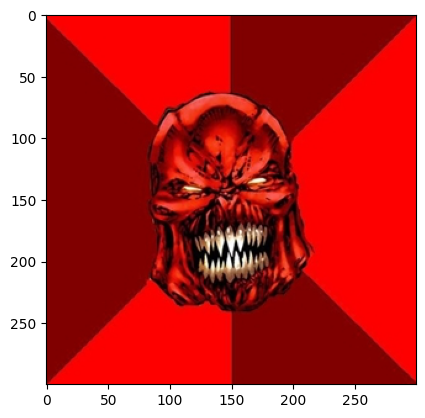

In [26]:
seen_path = random.choice(list(d_train.keys()))

pred_cap_seen = sample1Caption(seen_path, corpus, preprocess, model, 1000)

gt_cap_seen = d_train[seen_path][:5]

imshow(Image.open(seen_path))

print(f"Some ground truth captions for this seen image (1): {gt_cap_seen}")

print(f"Caption sampled by fintuned CLIP for this seen image: {pred_cap_seen}")

Some ground truth captions for this seen image (2): ['while im listening to lana del reys VIDEO games', 'Hornets attacked my mouth ', 'Put Your Dick in my Butt Video games', '8321783 unreleased songs all flawless', 'we were born this way i mean born to die']
Caption sampled by custom CLIP for this seen image: Is 22HAS BEEN IN LOVE ENOUGH   to write 4 albums...WTF?


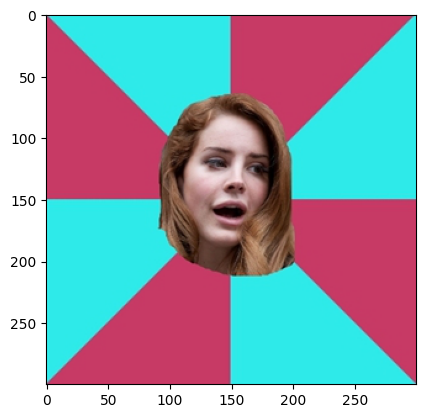

In [27]:
seen_path_cs = random.choice(list(d_seg_train.keys()))

pred_cap_seen_cs = sample1Caption(seen_path_cs, corpus_cs, preprocess_cs, model_cs, 1000)

gt_cap_seen_cs = d_seg_train[seen_path_cs][:5]

print(f"Some ground truth captions for this seen image (2): {gt_cap_seen_cs}")

imshow(Image.open(seen_path_cs))

print(f"Caption sampled by custom CLIP for this seen image: {pred_cap_seen_cs}")

Some ground truth captions for this seen image (3): ['Cries more than a newborn', 'cutler trade value 1 pack of chewing gum', "I don't always throw inTerceptions.... Oh wait. Yes I do. ", 'Tries to throw teammates under the bus intercepted', 'you laugh at my interceptions I Laugh at your saleries and girlfriends']
Caption sampled by one epoch CLIP for this seen image: I don't all ways throw interceptions but when i do, they're accurate


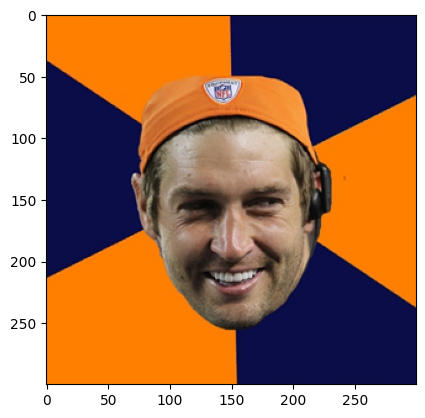

In [28]:
seen_path_1e = random.choice(list(d_seg_train.keys()))

pred_cap_seen_1e = sample1Caption(seen_path_1e, corpus_1e, preprocess_1e, model_1e, 1000)

gt_cap_seen_1e = d_seg_train[seen_path_1e][:5]

print(f"Some ground truth captions for this seen image (3): {gt_cap_seen_1e}")

imshow(Image.open(seen_path_1e))

print(f"Caption sampled by one epoch CLIP for this seen image: {pred_cap_seen_1e}")

# Distillation

## Model Distillation (VisualTransformer)

In [ ]:
student_clip_12_heads = VisualTransformer(input_resolution=224,patch_size=32,width=768//2,layers=12//2,heads=12,output_dim=512)